<a href="https://colab.research.google.com/github/Kapil3003/RemoteSensing_ImageSegmentation/blob/main/Farmonaut_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment
make a python program which can:
1. Takes minimum latitude, maximum latitude, minimum longitude, maximum longitude coordinates of a location as an Input
2. Retrieve the Google map image of these coordinates from the Google Maps static API at the maximum zoom level
3. Segments the Google map image using the segment anything model
4. calculates the polygon coordinates (lat , lon) for every identified segmented polygon.
5. creates a single GeoJSON object containing coordinates of all the objects.


---
## Setup


### GPU Setup

In [ ]:
!nvidia-smi

Mon Nov 27 03:07:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###  Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install supervision
!pip install geojson
!pip install leafmap

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.1 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P {HOME}/weights

CHECKPOINT_PATH_h = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
CHECKPOINT_PATH_b = os.path.join(HOME, "weights", "sam_vit_b_01ec64.pth")

print(CHECKPOINT_PATH_h, "; exist:", os.path.isfile(CHECKPOINT_PATH_h))
print(CHECKPOINT_PATH_b, "; exist:", os.path.isfile(CHECKPOINT_PATH_b))

HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True
/content/weights/sam_vit_b_01ec64.pth ; exist: True


---

## Task 1
1. Takes minimum latitude, maximum latitude, minimum longitude, maximum longitude coordinates of a location as an Input



### User Input for latitude and longitude

In [ ]:
## Import all required libraries

import ipywidgets as widgets
from IPython.display import display, clear_output
import requests
import math
import threading
import numpy as np
import pandas as pd
import cv2
import geojson
import os
import leafmap.foliumap as leafmap
import matplotlib.pyplot as plt
import supervision as sv

from google.colab import userdata
API_KEY = userdata.get('API_KEY')

In [ ]:
def validate_inputs(button):
    global min_latitude, max_latitude, min_longitude, max_longitude

    min_lat = min_lat_widget.value
    max_lat = max_lat_widget.value
    min_lon = min_lon_widget.value
    max_lon = max_lon_widget.value

    if (max_lat < min_lat or max_lon < min_lon or
        min_lat < -85 or max_lat > 85 or
        min_lon < -180 or max_lon > 180):

        clear_output()
        display(min_lat_widget, max_lat_widget, min_lon_widget, max_lon_widget, validate_button)

        print("Please enter valid values:")
        print("Make Sure :- Maximum > Minimum")
        print("Latitude Range :- (-90 to 90)")
        print("Longitude Range :- (-180 to 180)")

        min_latitude = -15.784482
        max_latitude = -15.782489
        min_longitude = -47.526908
        max_longitude = -47.524708

    else:
        clear_output()
        display(min_lat_widget, max_lat_widget, min_lon_widget, max_lon_widget, validate_button)
        print("Values are valid. Coordinates saved.")

        # Save the validated values to variables


        min_latitude = min_lat
        max_latitude = max_lat
        min_longitude = min_lon
        max_longitude = max_lon

    print(min_latitude, max_latitude, min_longitude, max_longitude)


# Creating FloatText widgets

# Default values for latitude and longitude
min_latitude = -15.784482
max_latitude = -15.782489
min_longitude = -47.526908
max_longitude = -47.524708

min_lat_widget = widgets.FloatText(description='Min Latitude:', value=min_latitude)
max_lat_widget = widgets.FloatText(description='Max Latitude:', value=max_latitude)
min_lon_widget = widgets.FloatText(description='Min Longitude:', value=min_longitude)
max_lon_widget = widgets.FloatText(description='Max Longitude:', value=max_longitude)

# Creating a button to validate inputs
validate_button = widgets.Button(description='Validate Inputs')
validate_button.on_click(validate_inputs)

# Display widgets and button
display(min_lat_widget, max_lat_widget, min_lon_widget, max_lon_widget, validate_button)


FloatText(value=-15.784482, description='Min Latitude:')

FloatText(value=-15.782489, description='Max Latitude:')

FloatText(value=-47.526908, description='Min Longitude:')

FloatText(value=-47.524708, description='Max Longitude:')

Button(description='Validate Inputs', style=ButtonStyle())

In [ ]:
## Test co-ordinates
min_latitude = -15.784544
max_latitude = -15.778587
min_longitude = -47.528411
max_longitude = -47.522123

# ## Test co-ordinates
# min_latitude = -15.784754
# max_latitude = -15.783521
# min_longitude = -47.542632
# max_longitude = -47.539386


---
## Task 2

2. Retrieve the Google map image of these coordinates from the Google Maps static API at the maximum zoom level

### Find Max zoom level




Find zoom level at 5 points - all 4 corners and center - take minimum of that



In [ ]:
def fetch_best_zoom_map_image(lat, lon, api_key):
    print("Checking zoom level @ ",lat, lon)
    base_url = 'https://maps.googleapis.com/maps/api/staticmap?'

    max_zoom = 22  # Maximum zoom level (as per API  - 21 is max zoom level so we will check from that )
    content_length_history = 0

    for zoom in range(max_zoom, 0, -1):

        params = {
            'center': f'{lat},{lon}',
            'zoom': str(zoom),
            'size': '640x640',
            'maptype': 'hybrid',
            'key': api_key,
            'scale' : 2,
        }

        response = requests.get(base_url, params=params)


        if (response.status_code == 200) :

            # Check the size of the returned image file
            content_length = int(response.headers['content-length'])

            if (int(response.headers['content-length']) > 10000) : # For tile to exist at tjat resolution
                print(f"Zoom level: {zoom}, Image size: {content_length} bytes")

                if content_length_history != 0 :
                    if content_length != content_length_history :
                        break

                content_length_history = content_length
            else :
                print(f"Zoom level: {zoom}, no map tiles exist at this zoom level")

        else:
            print(f"Zoom level: {zoom}, Error fetching: {response.status_code}")


    print("Max zoom level available @ ", zoom+1,"\n")



    return zoom+1


# Calculating center of bounding box
center_lat = (min_latitude + max_latitude)/2
center_lon = (min_longitude + max_longitude)/2

# Store the zoom levels for each combination in an array
zoom_levels = []

print("Checking max zoom available at four Corners and a Center\n")
# Fetch and store zoom levels for each combination
zoom_levels.append(fetch_best_zoom_map_image(min_latitude, min_longitude, API_KEY))
zoom_levels.append(fetch_best_zoom_map_image(min_latitude, max_longitude, API_KEY))
zoom_levels.append(fetch_best_zoom_map_image(max_latitude, min_longitude, API_KEY))
zoom_levels.append(fetch_best_zoom_map_image(max_latitude, max_longitude, API_KEY))
zoom_levels.append(fetch_best_zoom_map_image(center_lat, center_lon, API_KEY))


# Find the max zoom level available for all points
zoom_level = min(zoom_levels)

print('─' * 50)
print("Max Zoom Level available for all points in Bounding Box is - ",zoom_level)


Checking max zoom available at four Corners and a Center

Checking zoom level @  -15.784544 -47.528411
Zoom level: 22, Image size: 380588 bytes
Zoom level: 21, Image size: 380588 bytes
Zoom level: 20, Image size: 535215 bytes
Max zoom level available @  21 

Checking zoom level @  -15.784544 -47.522123
Zoom level: 22, Image size: 410918 bytes
Zoom level: 21, Image size: 410918 bytes
Zoom level: 20, Image size: 592362 bytes
Max zoom level available @  21 

Checking zoom level @  -15.778587 -47.528411
Zoom level: 22, Image size: 386454 bytes
Zoom level: 21, Image size: 386454 bytes
Zoom level: 20, Image size: 640682 bytes
Max zoom level available @  21 

Checking zoom level @  -15.778587 -47.522123
Zoom level: 22, Image size: 253056 bytes
Zoom level: 21, Image size: 253056 bytes
Zoom level: 20, Image size: 424741 bytes
Max zoom level available @  21 

Checking zoom level @  -15.7815655 -47.525267
Zoom level: 22, Image size: 374979 bytes
Zoom level: 21, Image size: 374979 bytes
Zoom level

### Find Total image size, No. of Imaages and update co-ordinates

In [ ]:
def least_count(zoom_level,lat):
    ## Note this function is not very accurate - but still performs very well for zoom_level> 10

    TILE_SIZE = 256

    ## Check https://developers.google.com/maps/documentation/javascript/examples/map-coordinates
    ## World coordinates in Google Maps are measured from the Mercator projection's origin (the northwest corner of the map at 180 degrees longitude and approximately 85 degrees latitude)

    ## Because the basic Mercator Google Maps tile is 256 x 256 pixels, the usable world coordinate space is {0-256}, {0-256}
    ## For example, at zoom level 1, the map consists of 4 256x256 pixels tiles, resulting in a pixel space from 512x512. At zoom level 19, each x and y pixel on the map can be referenced using a value between 0 and 256 * 219.

    Total_number_of_pixels  = pow(2, zoom_level)* TILE_SIZE


    ## Not convinced completely but working - Need to go deeper into this conversion
    # https://stackoverflow.com/questions/47106276/converting-pixels-to-latlng-coordinates-from-google-static-image/47243808#47243808
    longitud_least_count = 360 / Total_number_of_pixels

    parallelMultiplier = math.cos(lat * math.pi / 180)
    latitude_least_count = 360 / Total_number_of_pixels * parallelMultiplier

    return latitude_least_count,longitud_least_count


center_lat = (min_latitude + max_latitude)/2
center_lon = (min_longitude + max_longitude)/2
print("Center :-",center_lat,center_lon)

latitude_least_count,longitud_least_count =  least_count(zoom_level,center_lat)
print("Least count for Lat and Lon @ zoom level =",zoom_level,"is : ",latitude_least_count,longitud_least_count)
print('─' * 50)
print('─' * 50)

lat_pixels =  ((max_latitude - min_latitude)/latitude_least_count)
lon_pixels =  ((max_longitude - min_longitude)/longitud_least_count)
print("Require Image Size to cover BB: Lat = ",lat_pixels,",Lon = ",lon_pixels)
print('─' * 50)

# Update bounding box to have integer image size
print("Updating Bounding box to have integer image size")
min_lat_updated = center_lat - math.ceil(lat_pixels)/2 * latitude_least_count
max_lat_updated = center_lat + math.ceil(lat_pixels)/2 * latitude_least_count
min_lon_updated = center_lon - math.ceil(lon_pixels)/2 * longitud_least_count
max_lon_updated = center_lon + math.ceil(lon_pixels)/2 * longitud_least_count

# lat_pixels = int(lat_pixels/ 640 + 1) * 640
# lon_pixels = int(lon_pixels/ 640 + 1) * 640

# min_lat_updated = center_lat - (lat_pixels)/2 * latitude_least_count
# max_lat_updated = center_lat + (lat_pixels)/2 * latitude_least_count
# min_lon_updated = center_lon - (lon_pixels)/2 * longitud_least_count
# max_lon_updated = center_lon + (lon_pixels)/2 * longitud_least_count


print("Original Co-ordinates", min_latitude, max_latitude, min_longitude, max_longitude)
print("Updated  Co-ordinates", min_lat_updated, max_lat_updated, min_lon_updated, max_lon_updated)
print('─' * 50)

lat_pixels =  int((max_lat_updated - min_lat_updated)/latitude_least_count)
lon_pixels =  int((max_lon_updated - min_lon_updated)/longitud_least_count)

print("Updated Image Size: Lat = ",lat_pixels,",Lon = ",lon_pixels)
print('─' * 50)

print('─' * 50)
#Split Geometry into Grid - less than 640 by 640
num_images_lat = math.ceil((max_latitude - min_latitude)/latitude_least_count/640)
num_images_lon = math.ceil((max_longitude - min_longitude)/longitud_least_count/640)

print("Max Resolution Availble is 640*640 hence we need - " , num_images_lat,num_images_lon, "Images in lat direction and lon direction respectively")
print("Total Images required = ",num_images_lat*num_images_lon )



Center :- -15.7815655 -47.525267
Least count for Lat and Lon @ zoom level = 21 is :  6.45276153922474e-07 6.705522537231445e-07
──────────────────────────────────────────────────
──────────────────────────────────────────────────
Require Image Size to cover BB: Lat =  9231.706400103747 ,Lon =  9377.345262930128
──────────────────────────────────────────────────
Updating Bounding box to have integer image size
Original Co-ordinates -15.784544 -15.778587 -47.528411 -47.522123
Updated  Co-ordinates -15.784544094726506 -15.778586905273492 -47.52841121951771 -47.52212278048229
──────────────────────────────────────────────────
Updated Image Size: Lat =  9232 ,Lon =  9378
──────────────────────────────────────────────────
──────────────────────────────────────────────────
Max Resolution Availble is 640*640 hence we need -  15 15 Images in lat direction and lon direction respectively
Total Images required =  225


### Download Images

In [ ]:
def download_response_google_map_image(min_lat, max_lat, min_lon, max_lon,zoom_level,size_lat,size_lon,API_KEY):

    base_url = 'https://maps.googleapis.com/maps/api/staticmap?'

    params = {
        'center': f'{(min_lat + max_lat) / 2},{(min_lon + max_lon) / 2}',
        'zoom': str(zoom_level),
        'size': f"{size_lon}x{size_lat }",  # The maximum image size for googleapi is 640
        'maptype': 'satellite',  # Map type (can be changed) - roadmap, satellite, hybrid, and terrain   - which one to select
        'key': API_KEY,
        'scale': 1,
    }
    response = requests.get(base_url, params=params)

    if response.status_code != 200:

        print("Failed to download the image.")

    return response



def thread_fun_download(i,j):
    # Calculate the coordinates for each tile
    global num_images_lon,num_images_lat,min_lon_updated,max_lat_updated,longitud_least_count,latitude_least_count,lon_pixels,lat_pixels,zoom_level,API_KEY,full_map

    # Calculate tile size and coordinates based on indices i and j
    if i != num_images_lon-1:
        size_lon = 640
        tile_min_lon = min_lon_updated + ( i * 640 * longitud_least_count)
        tile_max_lon = min_lon_updated + ((i + 1) * 640 * longitud_least_count)
    else:
        size_lon = lon_pixels%640
        tile_min_lon = min_lon_updated + ( i * 640 * longitud_least_count)
        tile_max_lon = tile_min_lon + size_lon  *longitud_least_count


    if j != num_images_lat-1:
        size_lat = 640
        tile_max_lat  = max_lat_updated - ( j * 640 * latitude_least_count)
        tile_min_lat = max_lat_updated - ((j + 1) * 640 * latitude_least_count)

    else:
        size_lat = lat_pixels%640
        tile_max_lat = max_lat_updated - ( j * 640 * latitude_least_count)
        tile_min_lat = tile_max_lat - size_lat  *latitude_least_count

    # Fetch the image using requests
    response = download_response_google_map_image(tile_min_lat, tile_max_lat, tile_min_lon, tile_max_lon,zoom_level,size_lat,size_lon,API_KEY)
    # Decode the image using OpenCV and save the tile image
    tile_image = cv2.imdecode(np.array(bytearray(response.content), dtype=np.uint8),-1)

    with open('./Data/Tile'+ str(j).zfill(5)+ '_' +str(i).zfill(5) +'.png', 'wb') as file:
        file.write(response.content)



# Create directory if not exists

directory_name = "Data"
current_directory = os.getcwd()
new_directory_path = os.path.join(current_directory, directory_name)

if not os.path.exists(new_directory_path):

    os.makedirs(new_directory_path)
else:
  pass




print("Downloading Images")

### Need to use threading to download the images faster
threads = []
batch_size = 20  # Set the batch size (number of threads) to run parallel
processed_images = 0  # Counter for processed images


# Fetch all images
for i in range(num_images_lon):
    for j in range(num_images_lat):

        x = threading.Thread(target=thread_fun_download, args=(i,j,))
        threads.append(x)
        x.start()

        processed_images = processed_images +1

        # Check if the number of threads created reaches the batch size
        if len(threads) == batch_size:
            # Wait for all threads in this batch to complete
            for thread in threads:
                thread.join()

            # Clear the threads list for the next batch
            threads = []

            print("Completion % ",processed_images*100/num_images_lon/num_images_lat)


print("Completion % ",100.0)


Completion %  8.88888888888889
Completion %  17.77777777777778
Completion %  26.666666666666668
Completion %  35.55555555555556
Completion %  44.44444444444444
Completion %  53.333333333333336
Completion %  62.22222222222222
Completion %  71.11111111111111
Completion %  80.0
Completion %  88.88888888888889
Completion %  97.77777777777779
Completion %  100.0


### Stich together images for complete bounding box

stiching done !
Required Image size - Lat =  9232  ,Lon =  9378
Size of the stiched image -  (9232, 9378, 3)
Plotting Image


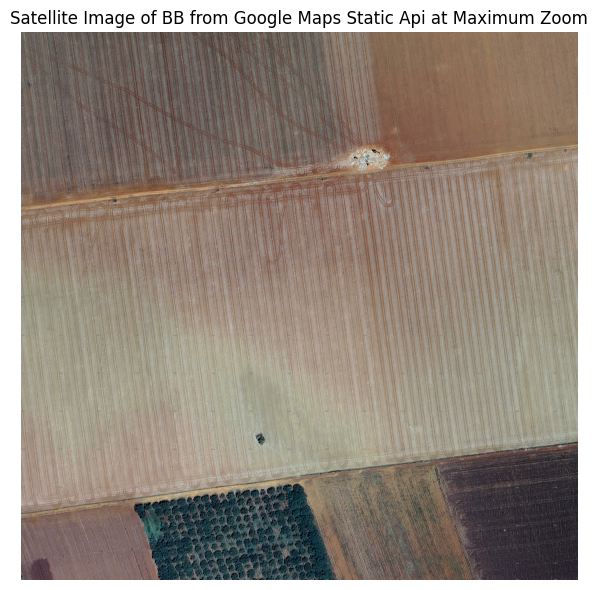

In [ ]:
# Stiching all the images together

# Initialize a blank canvas to stitch images together
full_map = np.zeros((lat_pixels, lon_pixels, 3), dtype=np.uint8)

for i in range(num_images_lon):
    for j in range(num_images_lat):

        # Calculate the positions to stitch the current tile image
        i_path  = './Data/Tile'+ str(j).zfill(5)+ '_' +str(i).zfill(5) +'.png'
        tile_image = cv2.imread(i_path)

        size_lon = 640
        size_lat = 640

        y_start = i * size_lon
        y_end = (i + 1) * size_lon

        x_start = j * size_lat
        x_end =  (j + 1) * size_lat


        if i == num_images_lon-1:
            y_end = y_start + lon_pixels%640

        if j == num_images_lat-1:
            size_lat = lat_pixels%640
            x_end = x_start + size_lat


        # Paste the current tile image onto the blank canvas
        full_map[x_start:x_end,y_start:y_end ] = tile_image

# Converting Image to RGB
full_map = cv2.cvtColor(full_map, cv2.COLOR_BGR2RGB)
print("stiching done !")
print("Required Image size - Lat = ",lat_pixels," ,Lon = ",lon_pixels)
print("Size of the stiched image - ",full_map.shape)


print("Plotting Image")

# Also saving the image
cv2.imwrite('stitched_image.png', full_map)

plt.figure(figsize=(12, 6))
plt.imshow(full_map)
plt.title('Satellite Image of BB from Google Maps Static Api at Maximum Zoom')
plt.axis('off')
plt.tight_layout()
plt.show()

## Task 3

3. Segments the Google map image using the segment anything model

### Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE_h = "vit_h"
MODEL_TYPE_b = "vit_b"

CHECKPOINT_PATH_b
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_h = sam_model_registry[MODEL_TYPE_h](checkpoint=CHECKPOINT_PATH_h).to(device=DEVICE)
# mask_generator = SamAutomaticMaskGenerator(sam_h)

## Lets use lighter model
sam_b = sam_model_registry[MODEL_TYPE_b](checkpoint=CHECKPOINT_PATH_b).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam_b)   ## Need to explore parameters for SamAutomaticMaskGenerator

### Automated Mask Generation Generate masks with SAM

###### Improvements Needed

Aything above images size >  3000*3000 will require more GPU.

Other ways to process
1. Downsize the image :- You loose the image quality and small details - wasting the data from highquality max zoom image
2. Small Batchwise processing :- You loose the global sense - but should work for satellite images, figure out how to stich masks of each patch


For now any image having > 9x10^6 wil be downsized to pixel < 9*10^6

2nd option is the preferred method - need to explore and implement

resources for 2nd option
  - [patchify - bathchwise segmentation](https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py)

- Also needs improvement in tuning the models - Need to explore parameters for SamAutomaticMaskGenerator

In [ ]:
# Give the path of your image
IMAGE_PATH= '/content/stitched_image.png'

# Read the image from the path
image_o= cv2.imread(IMAGE_PATH)
# Convert to RGB format
image_rgb = image_o  #cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Already it is saved as rgb - so no need


## Check Resizing Condition
total_pixels = image_o.shape[0]*image_o.shape[1]

if total_pixels > 3000*3000:
    downsize_by = ( total_pixels/3000/3000)

    dim = (int(image_rgb.shape[1]/downsize_by),int(image_rgb.shape[0]/downsize_by))


    # resize the image

    image_rgb = cv2.resize(image_rgb, dim, interpolation = cv2.INTER_AREA)

    print("Image Resized due to large size ! , New Size = ", image_rgb.shape  )



# Generate segmentation mask
print("Image Segmentation Started")
sam_result = mask_generator.generate(image_rgb)
print("Image Segmentation Done !")

torch.cuda.empty_cache()  ## Freeup GPU memory


Image Resized due to large size ! , New Size =  (959, 974, 3)
Image Segmentation Started
Image Segmentation Done !


In [ ]:
# Need to explore parameters for SamAutomaticMaskGenerator

# ### For now - lets go forward with simple  mask_generator = SamAutomaticMaskGenerator(sam)

# mask_generator_2 = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=32,
#     pred_iou_thresh=0.86,
#     stability_score_thresh=0.92,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=100,  # Requires open-cv to run post-processing
# )

# sam_result2 = mask_generator_2.generate(image_rgb)

### Results visualisation

 You can write your own functions to extract info need from sam_result but [supervision](https://supervision.roboflow.com/) has already done it.

 So we will just use this library to extract detection , annotate mask and recover polygons.

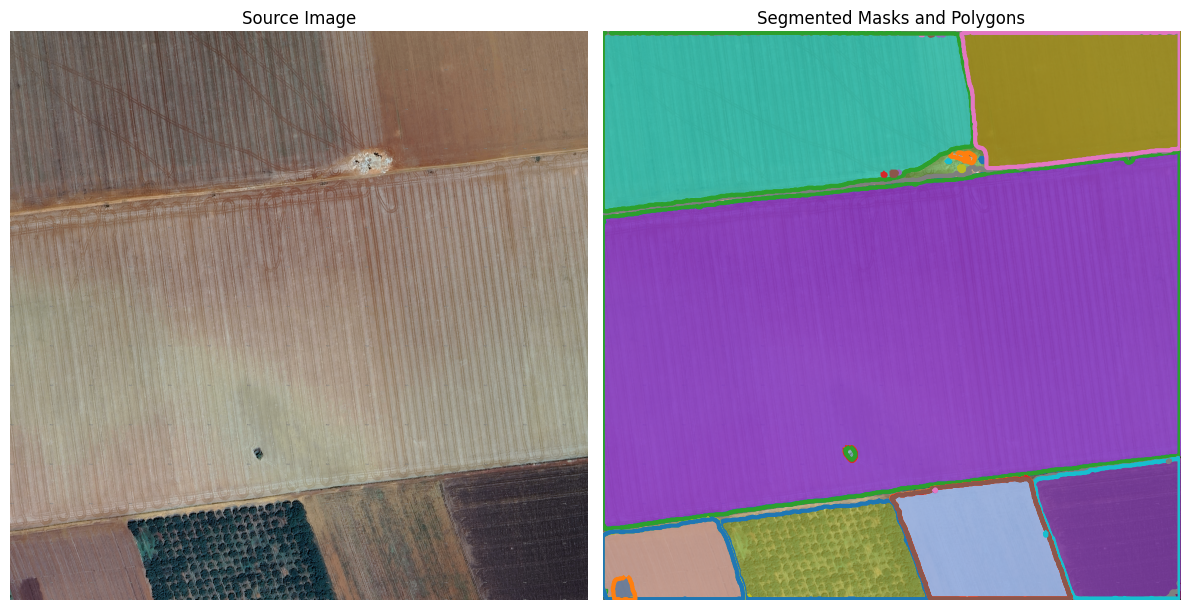

In [ ]:
# Extract all detections
detections = sv.Detections.from_sam(sam_result=sam_result)

# Extract polygons from mask
polygons = [sv.mask_to_polygons(m) for m in detections.mask]

# Annotate the mask
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated_image_mask = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)


# Plot results


plt.figure(figsize=(12, 6))

# Plot the source image
plt.subplot(1, 2, 1)
plt.imshow(image_o)
plt.title('Source Image')
plt.axis('off')

# Plot the segmented mask and polygons on the image
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)

plt.imshow(annotated_image_mask, alpha=1)  # Overlay masks on the original image

for polygon in polygons:
    for coords in polygon:
        plt.plot(coords[:, 0], coords[:, 1], linewidth=3)

plt.title('Segmented Masks and Polygons')
plt.axis('off')

plt.tight_layout()
plt.show()

## Task 4

4. calculates the polygon coordinates (lat , lon) for every identified segmented polygon.



----

Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Extract polygons pixels from mask

In [ ]:
# Extract polygons from mask

detections = sv.Detections.from_sam(sam_result=sam_result)
polygons = [sv.mask_to_polygons(m) for m in detections.mask]

### Convert Polygon Pixel to Lat Lon

In [ ]:
# Define a function to multiply x and y coordinates
def pixel2coordinates(coords):
    if coords is not None:
        return [[(min_lon_updated + final_longitud_least_count * (x)), (max_lat_updated -  final_latitude_least_count*(y))] for x, y in coords]
    return None


# Find the least count of the Final Image that was segmented

final_latitude_least_count = latitude_least_count * lat_pixels /  image_rgb.shape[0]
final_longitud_least_count = longitud_least_count * lon_pixels /  image_rgb.shape[1]

# Convert to df for ease of calculations
df_polygons=pd.DataFrame(polygons)
df_cordinates = pd.DataFrame()

# Apply the function to each column of the DataFrame
for col in df_polygons.columns:
    df_cordinates[col] = df_polygons[col].apply(pixel2coordinates)

df_cordinates.head()

,0,1,2,3,4
0,"[[-47.522245450237605, -15.779847916179605], [...","[[-47.525751222718334, -15.782941430619228], [...",None,None,None
1,"[[-47.52223899393469, -15.779847916179605], [-...","[[-47.525751222718334, -15.782941430619228], [...","[[-47.5247440394642, -15.778617964655416], [-4...","[[-47.52485379661369, -15.778617964655416], [-...","[[-47.52494418485444, -15.778617964655416], [-..."
2,"[[-47.524421224318644, -15.778586905273492], [...","[[-47.52452452516522, -15.780003213089223], [-...","[[-47.52466010752636, -15.779941094325377], [-...","[[-47.52428564195751, -15.779910034943452], [-...","[[-47.52454389407396, -15.779860339932375], [-..."
3,"[[-47.52838539430606, -15.778599329026262], [-...","[[-47.525350931937844, -15.780071543729457], [...","[[-47.52518952436507, -15.780059119976688], [-...","[[-47.525254087394174, -15.780052908100302], [...",None
4,"[[-47.52441476801573, -15.778586905273492], [-...",None,None,None,None


## Task 5

5. creates a single GeoJSON object containing coordinates of all the objects.

### Create GeoJSON object and Save file

In [ ]:
# Create an empty list to store features
features = []

for row in range(0, len(df_cordinates)):

    # Create a GeoJSON  feature for each row

    polygon_obj = geojson.Polygon(df_cordinates.iloc[row].dropna().tolist())
    feature_obj = geojson.Feature(geometry= polygon_obj, properties={})

    # Append the feature to the list of features
    features.append(feature_obj)

# Create a FeatureCollection from the list of features
feature_collection = geojson.FeatureCollection(features)

# Convert FeatureCollection to GeoJSON string
geojson_str = geojson.dumps(feature_collection, sort_keys=True)

# Save the GeoJSON string to a file
with open('polygon_coordinates.geojson', 'w') as file:
    file.write(geojson_str)

print("GeoJSON file saved successfully.")


GeoJSON file saved successfully.


### Visualize and verify the GeoJson results


In [ ]:
file_path = os.path.abspath('/content/polygon_coordinates.geojson')

with open(file_path) as f:
    json_data = geojson.load(f)

m = leafmap.Map(center=( center_lat,center_lon), zoom=zoom_level)
m.add_basemap(google_map="SATELLITE")

m.add_geojson(json_data, layer_name="Segmented Polygons", hover_style={'fillColor': 'red'})
m